In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
JRA_data = xr.open_mfdataset('/g/data/e14/txs156/Data/Observations/JRA/JRA_ACCESS/JRA_ACCESS_fluxes_combi.nc')


In [2]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41005/status,
Dashboard: /proxy/41005/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45407,Workers: 7
Dashboard: /proxy/41005/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:43263,Total threads: 4
Dashboard: /proxy/33643/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:46527,


In [3]:
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [4]:
lat_slice = slice(-80, -59)
start_time, end_time = '2170-01-01', '2180-12-31'

# Import bathymetry - t-grid
ht = cc.querying.getvar(expt, 'ht', session, n=1)
ht = ht.sel(yt_ocean=lat_slice)
# Import bathymetry - u-grid
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)

# Import properties to average
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)



/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [5]:
%%time
# thickness / area for depth averaging (not time varying):

xt_ocean = cc.querying.getvar(expt,'xt_ocean' , session,n=1)
yt_ocean = cc.querying.getvar(expt,'yt_ocean' , session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_t = cc.querying.getvar(expt,'area_t',session,n=1)
area_t = area_t.sel(yt_ocean=lat_slice)

volume = area_t*thickness
volume = volume.load()



CPU times: user 17.5 s, sys: 9.83 s, total: 27.3 s
Wall time: 30.5 s


In [6]:
%%time
# thickness / area for depth averaging (not time varying):

xu_ocean = cc.querying.getvar(expt,'xu_ocean' , session,n=1)
yu_ocean = cc.querying.getvar(expt,'yu_ocean' , session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':yu_ocean,'xu_ocean':xu_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_u = cc.querying.getvar(expt,'area_u',session,n=1)
area_u = area_u.sel(yu_ocean=lat_slice)

volume_u = area_u*thickness_u
volume_u = volume_u.load()


CPU times: user 16.1 s, sys: 9.27 s, total: 25.4 s
Wall time: 26.9 s


## Do any masking prior to binning with $\textit{xhistogram}$

In [ ]:
# We need to define a mask based on the time, longitudes that CSHT is high onto the shelf, vs high off the shelf, AND the 3 regimes identified by the regime mask .

In [ ]:
# Load regime mask
regimes xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')

# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# Define the mask as all depths around Antarctica shallower than 3000m 



In [10]:
CSHT_months

NameError: name 'CSHT_months' is not defined

In [7]:
%%time
bins_isobath = st_edges_ocean.values

V_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume)
Vu_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u)

A_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = area_t)
Au_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = area_u)

TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)
uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)

T_mean = TV_sum/V_sum
S_mean = SV_sum/V_sum
rho_mean = rhoV_sum/V_sum
u_mean = uV_sum/Vu_sum

T_mean.load()
rho_mean.load()
S_mean.load()
u_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

CPU times: user 13min 30s, sys: 1min 34s, total: 15min 4s
Wall time: 23min 24s


<xarray.DataArray 'histogram_hu' (st_ocean: 75, time: 120, hu_bin: 75)> Size: 5MB
array([[[            nan,             nan,             nan, ...,
          4.05975686e-02,  4.12732474e-02,  6.01062146e-02],
        [            nan,             nan,             nan, ...,
          4.15199676e-02,  5.38150199e-02,  4.13251893e-02],
        [            nan,             nan,             nan, ...,
          6.61073310e-02,  7.12303761e-02,  6.89550713e-02],
        ...,
        [            nan,             nan,             nan, ...,
          7.69601574e-02,  1.04626317e-01,  1.04431065e-01],
        [            nan,             nan,             nan, ...,
          6.56446770e-02,  8.78900100e-02,  8.99413898e-02],
        [            nan,             nan,             nan, ...,
          4.06922380e-02,  6.28180915e-02,  6.52832649e-02]],

       [[            nan,             nan,             nan, ...,
          3.05025664e-02,  2.85009924e-02,  4.40916999e-02],
        [            nan,             nan,             nan, ...,
          3.46681231e-02,  4.33691020e-02,  3.38612436e-02],
        [            nan,             nan,             nan, ...,
          5.11747317e-02,  5.37515217e-02,  5.35514688e-02],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,  4.32129905e-03],
        [            nan,             nan,             nan, ...,
                     nan,             nan,  5.92740309e-05],
        [            nan,             nan,             nan, ...,
                     nan,             nan,  2.66222796e-04]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * hu_bin   (hu_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

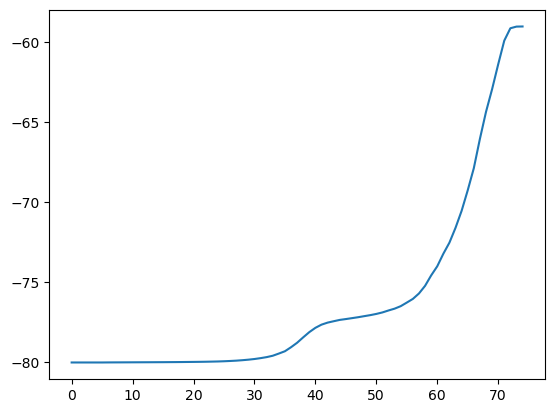

In [8]:
normalised_area_cumsum = A_sum.cumsum('ht_bin')/np.nansum(A_sum)
normalised_area_cumsum_u = Au_sum.cumsum('hu_bin')/np.nansum(Au_sum)

pseudo_lat = -1*(80-(80-59)*normalised_area_cumsum)
plt.plot(pseudo_lat.values)

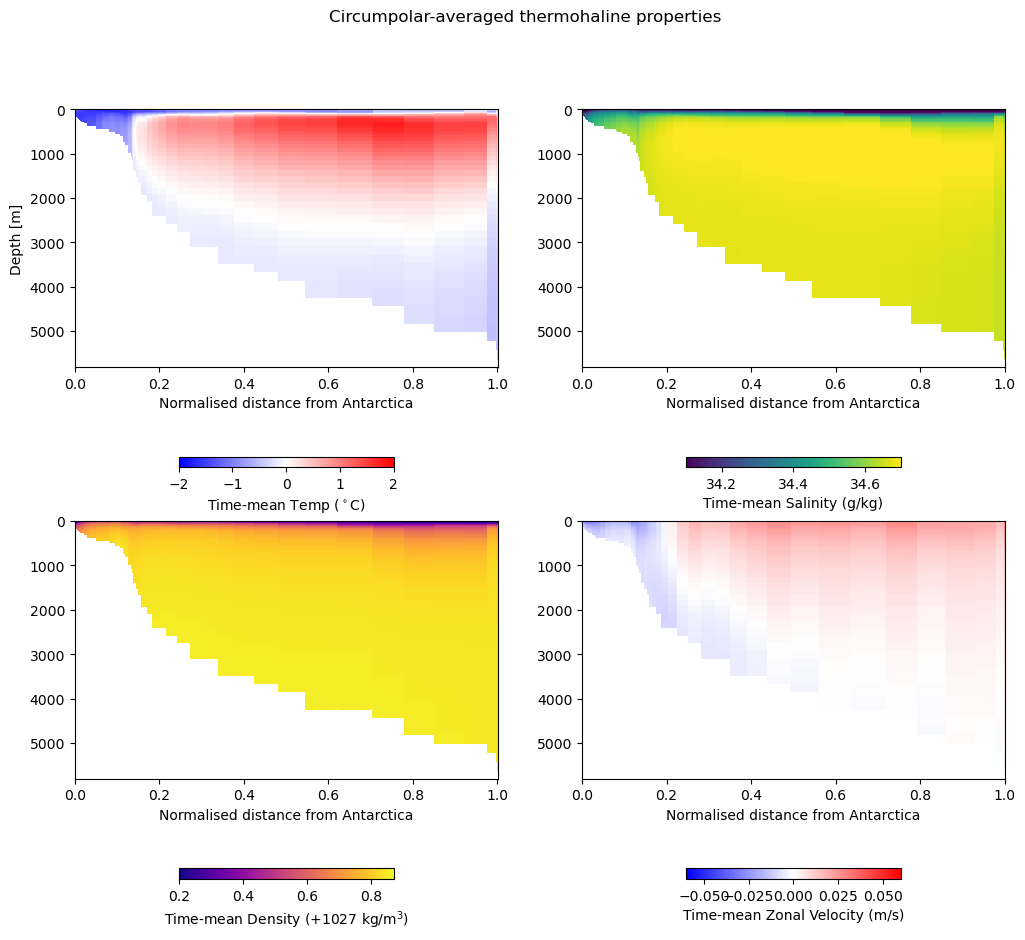

In [16]:
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Circumpolar-averaged thermohaline properties')
plt.savefig('/g/data/e14/txs156/Figures/Avg_thermohaline_props.png', dpi=300, bbox_inches='tight')
plt.show()